In [45]:
#importing libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [46]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [47]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [48]:
VOCAB_SIZE = 50000  # vocabulary size
MAX_LEN = 50

In [49]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [50]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


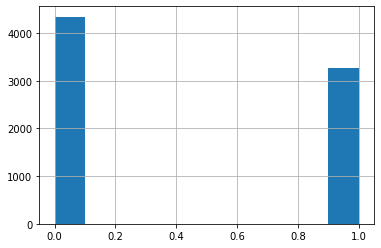

In [51]:
train_df["target"].hist()

data cleaning

In [52]:
import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
# for cleaning tweets
lemmatizer = WordNetLemmatizer()

def clean_data(tweet):
    tweet = re.sub("[@&]\w*", "", tweet)
    tweet = re.sub("https?:\S*", "", tweet)
    tweet = re.sub("[^A-Za-z#]", " ", tweet)
    tweet = tweet.lower()
    tweet = [lemmatizer.lemmatize(word) for word in tweet.split() if word not in stopwords.words("english")]
    tweet = " ".join(tweet)

    return tweet

In [54]:
# add clean text column
train_df["clean_text"] = train_df["text"].apply(clean_data)
test_df["clean_text"] = test_df["text"].apply(clean_data)

In [55]:
train_df[['text', 'clean_text']]

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason #earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",people receive #wildfires evacuation order cal...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby #alaska smoke #wildfires p...
...,...,...
7608,Two giant cranes holding a bridge collapse int...,two giant crane holding bridge collapse nearby...
7609,@aria_ahrary @TheTawniest The out of control w...,control wild fire california even northern par...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,utc km volcano hawaii
7611,Police investigating after an e-bike collided ...,police investigating e bike collided car littl...


#Data Preprocessing

In [56]:
# one hot encoding
train_df["text_ohe"] = train_df["clean_text"].apply(lambda x: one_hot(x, VOCAB_SIZE))
test_df["text_ohe"] = test_df["clean_text"].apply(lambda x: one_hot(x, VOCAB_SIZE))

In [57]:
train_df[['clean_text', 'text_ohe']].head()

,clean_text,text_ohe
0,deed reason #earthquake may allah forgive u,"[21522, 43542, 42189, 8828, 21201, 28073, 14464]"
1,forest fire near la ronge sask canada,"[5878, 39487, 12850, 26831, 19348, 23096, 31587]"
2,resident asked shelter place notified officer ...,"[8632, 34139, 26967, 45260, 21293, 40258, 3614..."
3,people receive #wildfires evacuation order cal...,"[46632, 5930, 24586, 36146, 37857, 20221]"
4,got sent photo ruby #alaska smoke #wildfires p...,"[22312, 17762, 26386, 49615, 47992, 32448, 245..."


Train-Test Split

In [58]:
X = train_df["text_ohe"].values
y = train_df["target"].values

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape)

(6090,) (1523,)


In [60]:
# pad_sequences
X_train = pad_sequences(X_train, MAX_LEN)
X_val = pad_sequences(X_val, MAX_LEN)

print(X_train.shape, X_val.shape)

(6090, 50) (1523, 50)


#Create Model

In [61]:
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")

# Embed each integer in a 128-dimensional vector
x = layers.Embedding(VOCAB_SIZE, 64)(inputs)

# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(32, kernel_regularizer=regularizers.l2(1e-3), recurrent_regularizer=regularizers.l2(1e-4), return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(32, kernel_regularizer=regularizers.l2(1e-3), recurrent_regularizer=regularizers.l2(1e-4)))(x)
x = layers.Dropout(0.2)(x)

# Add a classifier
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          3200000   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 64)         24832     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1040

In [62]:
model.compile(optimizer=tf.optimizers.RMSprop(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])

#Model Training

In [64]:
hist = model.fit(X_train, y_train, batch_size=30, epochs=10,
                 validation_data=(X_val, y_val))

Epoch 1/10
203/203 [==============================] - 56s 85ms/step - loss: 0.6765 - accuracy: 0.6941 - val_loss: 0.5001 - val_accuracy: 0.7912
Epoch 2/10
203/203 [==============================] - 15s 75ms/step - loss: 0.4046 - accuracy: 0.8414 - val_loss: 0.4858 - val_accuracy: 0.8004
Epoch 3/10
203/203 [==============================] - 16s 81ms/step - loss: 0.3385 - accuracy: 0.8722 - val_loss: 0.5138 - val_accuracy: 0.7676
Epoch 4/10
203/203 [==============================] - 15s 75ms/step - loss: 0.3030 - accuracy: 0.8911 - val_loss: 0.5066 - val_accuracy: 0.7892
Epoch 5/10
203/203 [==============================] - 15s 75ms/step - loss: 0.2795 - accuracy: 0.9010 - val_loss: 0.5024 - val_accuracy: 0.7748
Epoch 6/10
203/203 [==============================] - 15s 75ms/step - loss: 0.2604 - accuracy: 0.9100 - val_loss: 0.5258 - val_accuracy: 0.7866
Epoch 7/10
203/203 [==============================] - 16s 81ms/step - loss: 0.2448 - accuracy: 0.9149 - val_loss: 0.6047 - val_accuracy:

#Model evaluation

In [65]:
loss_df = pd.DataFrame(hist.history)
loss_df

,loss,accuracy,val_loss,val_accuracy
0,0.676508,0.694089,0.500120,0.791202
1,0.404607,0.841379,0.485759,0.800394
2,0.338490,0.872250,0.513842,0.767564
3,0.302999,0.891133,0.506574,0.789232
4,0.279521,0.900985,0.502434,0.774787
5,0.260415,0.910016,0.525837,0.786605
6,0.244782,0.914943,0.604677,0.770847
7,0.231498,0.922003,0.550201,0.779383
8,0.227454,0.925616,0.604603,0.761655
9,0.195418,0.938916,0.608950,0.762311


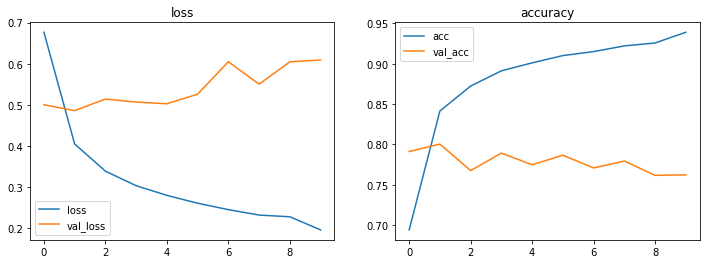

In [66]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_df["loss"], label="loss")
plt.plot(loss_df["val_loss"], label="val_loss")
plt.title("loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_df["accuracy"], label="acc")
plt.plot(loss_df["val_accuracy"], label="val_acc")
plt.title("accuracy")
plt.legend()

In [67]:
# Restore weights
model.load_weights(checkpoint_filepath)
scores = model.evaluate(X_val, y_val)

print(scores)

48/48 [==============================] - 1s 21ms/step - loss: 0.4858 - accuracy: 0.8004
[0.48575952649116516, 0.8003939390182495]


#Predictions

In [69]:
X_test = test_df["text_ohe"].values

In [71]:
# pad_sequences
X_test = pad_sequences(X_test, MAX_LEN)

print(X_test.shape)

(3263, 50)


In [72]:
y_pred = model.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

print(y_pred)

102/102 [==============================] - 4s 19ms/step
[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

In [73]:
output = pd.DataFrame({'id': test_df.id, 'target': y_pred})
output.to_csv('output.csv', index=False)

In [74]:
output = pd.read_csv("output.csv")

In [75]:
output.head(20)

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0
